<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#MNIST-Dataset" data-toc-modified-id="MNIST-Dataset-1">MNIST Dataset</a></span><ul class="toc-item"><li><span><a href="#Classifying-Digits-via-DenseNet-in-Tensorflow" data-toc-modified-id="Classifying-Digits-via-DenseNet-in-Tensorflow-1.1">Classifying Digits via DenseNet in Tensorflow</a></span><ul class="toc-item"><li><span><a href="#Ben-Fox-|-CS-281B-|-04/14/2019" data-toc-modified-id="Ben-Fox-|-CS-281B-|-04/14/2019-1.1.1">Ben Fox | CS 281B | 04/14/2019</a></span></li></ul></li></ul></li></ul></div>

# MNIST Dataset
## Classifying Digits via DenseNet in Tensorflow
### Ben Fox | CS 281B | 04/14/2019

In [6]:
# import modules
import numpy as np
import pickle
import matplotlib.pyplot as plt
import math
%matplotlib inline
import tensorflow as tf
from keras.utils.np_utils import to_categorical
tf.set_random_seed(0)

Using TensorFlow backend.


In [7]:
# get mnist data
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

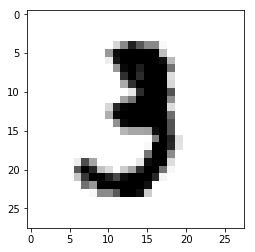

In [11]:
plt.imshow(x_train[10], cmap = 'gray_r')

In [4]:
y_train[10]

3

In [5]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [6]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train / 255
x_test = x_test / 255

In [12]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [13]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [36]:
# set tf placeholders for X and Y data
X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # placerholder, images are 28,28,1, None refers to batch size, will be filled during training
Y = tf.placeholder(tf.float32, [None, 10]) # placeholder, output is a 1 hot vector for the 10 possible classes
step = tf.placeholder(tf.float32) # place holder for the learning rate function
pkeep = tf.placeholder(tf.float32) # placeholder, dropout of neurons 

# 5 layers and corresponding layer dims
L1 = 200
L2 = 100
L3 = 50
L4 = 30

# build layers w/ dropout
W1 = tf.Variable(tf.truncated_normal([784, L1], stddev=0.1)) # this is the weights matrix, of random numbers of normal dist , 28*28 = 784 and weights for the input to second layer
B1 = tf.Variable(tf.ones([L1])/10) # bias for 200 neurons, initialize to non-zero small value

W2 = tf.Variable(tf.truncated_normal([L1, L2], stddev=0.1)) # 2nd layer, input 200, output 100
B2 = tf.Variable(tf.ones([L2])/10)

W3 = tf.Variable(tf.truncated_normal([L2, L3], stddev=0.1)) # 3rd layer, input 100, output 60 
B3 = tf.Variable(tf.ones([L3])/10)

W4 = tf.Variable(tf.truncated_normal([L3, L4], stddev=0.1)) # 4th layer, input 60, output 30
B4 = tf.Variable(tf.ones([L4])/10)

W5 = tf.Variable(tf.truncated_normal([L4, 10], stddev=0.1)) # 5th layer, input 30, output 10
B5 = tf.Variable(tf.zeros([10]))

# build the model
XX = tf.reshape(X, [-1,784]) # -1 means tf will figure out dimensionality to make X flat to 784 columns
Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1) # relu activation between layers
Y1d = tf.nn.dropout(Y1, pkeep)
Y2 = tf.nn.relu(tf.matmul(Y1d, W2) + B2)
Y2d = tf.nn.dropout(Y2, pkeep)
Y3 = tf.nn.relu(tf.matmul(Y2d, W3) + B3)
Y3d = tf.nn.dropout(Y3, pkeep)
Y4 = tf.nn.relu(tf.matmul(Y3d, W4) + B4)
Y4d = tf.nn.dropout(Y4, pkeep)
YLogits = tf.matmul(Y4d, W5) + B5 # save logits for cross entropy loss function, some logs might be 0
YPred = tf.nn.softmax(YLogits) # softmax activation for predict

# loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=YLogits, labels = Y) # use tf cross entropy loss, deals with log(0) problems
cross_entropy = tf.reduce_mean(cross_entropy)*100 # get loss in percentage

# learning rate, utlizing an exponential decay function
lr = 0.0001 + tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
optimizer = tf.train.AdamOptimizer(lr) # variable learning rate
train_step = optimizer.minimize(cross_entropy)

# measures
#is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(YPred,1))
accuracy = tf.metrics.accuracy(tf.argmax(Y,1), tf.argmax(YPred,1))
precision = tf.metrics.precision(tf.argmax(Y,1), tf.argmax(YPred,1))
recall = tf.metrics.recall(tf.argmax(Y,1), tf.argmax(YPred,1))

# initialize session
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess = tf.Session()
sess.run(init)
# init = tf.global_variables_initializer()
# sess = tf.Session() # begin and initialize tf session
# sess.run(init)

In [37]:
dnn_training_acc = []
dnn_testing_acc = []
dnn_train_prec = []
dnn_train_rec = []
dnn_test_prec = []
dnn_test_rec = []
dnn_learn_rate = []
dnn_train_cross_ent = []
dnn_test_cross_ent = []

In [38]:
def training_step(i, batch_x, batch_y, x_test, y_test, update_test_data, update_train_data, x_train):

    # compute training values for visualisation
    if update_train_data:
        a, c, l, p, r = sess.run([accuracy, cross_entropy, lr, precision, recall], feed_dict={X: batch_X, Y: batch_Y, pkeep: 1.0, step: i})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(l) + ")")
        dnn_training_acc.append(a)
        dnn_learn_rate.append(l)
        dnn_train_cross_ent.append(c)
        dnn_train_prec.append(p)
        dnn_train_rec.append(r)
        
    # compute test values for visualisation
    if update_test_data:
        a, c, p, r = sess.run([accuracy, cross_entropy, precision, recall], feed_dict={X: x_test, Y: y_test, pkeep: 1.0})
        print(str(i) + ": ********* epoch " + str(i*100//x_train.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        dnn_testing_acc.append(a)
        dnn_test_cross_ent.append(c)
        dnn_test_prec.append(p)
        dnn_test_rec.append(r)
        

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y: batch_Y, pkeep: 0.7, step: i}) 

epochs = 20
iterations = epochs * 600 # an epoch will complete every 600 iterations

for i in range(iterations+1): 
    if (i % 600 == 0):
        k = 0
        shf = np.random.choice(x_train.shape[0], 60000, replace=False)
        n = 100
        idx_batches = [shf[j:j + n] for j in range(0, len(shf), n)] 
    batch_X, batch_Y = x_train[idx_batches[k]], y_train[idx_batches[k]]
    k += 1
    training_step(i, batch_X, batch_Y, x_test, y_test, i % 100 == 0, i % 20 == 0, x_train)

0: accuracy:(0.0, 0.09) loss: 230.6654 (lr:0.0031)
0: ********* epoch 1 ********* test accuracy:(0.09, 0.10227723) test loss: 231.44208
20: accuracy:(0.10227723, 0.10617647) loss: 141.05354 (lr:0.0030701496)
40: accuracy:(0.10617647, 0.11242718) loss: 76.7388 (lr:0.0030405961)
60: accuracy:(0.11242718, 0.118942305) loss: 59.685307 (lr:0.0030113366)
80: accuracy:(0.118942305, 0.12609524) loss: 37.51021 (lr:0.0029823685)
100: accuracy:(0.12609524, 0.13339622) loss: 39.072807 (lr:0.0029536884)
100: ********* epoch 1 ********* test accuracy:(0.13339622, 0.50242716) test loss: 37.596245
120: accuracy:(0.50242716, 0.5043478) loss: 33.35981 (lr:0.0029252938)
140: accuracy:(0.5043478, 0.50629807) loss: 30.459986 (lr:0.0028971815)
160: accuracy:(0.50629807, 0.5081818) loss: 33.42779 (lr:0.002869349)
180: accuracy:(0.5081818, 0.51009524) loss: 28.39212 (lr:0.0028417937)
200: accuracy:(0.51009524, 0.5120853) loss: 22.649748 (lr:0.0028145125)
200: ********* epoch 1 ********* test accuracy:(0.51208

1860: accuracy:(0.911149, 0.91118354) loss: 2.9507742 (lr:0.001283661)
1880: accuracy:(0.91118354, 0.91121304) loss: 11.107164 (lr:0.0012718835)
1900: accuracy:(0.91121304, 0.9112325) loss: 25.165419 (lr:0.001260223)
1900: ********* epoch 4 ********* test accuracy:(0.9112325, 0.9142032) test loss: 10.810454
1920: accuracy:(0.9142032, 0.9142394) loss: 3.4137714 (lr:0.0012486785)
1940: accuracy:(0.9142394, 0.9142612) loss: 10.874089 (lr:0.0012372491)
1960: accuracy:(0.9142612, 0.9142782) loss: 16.151434 (lr:0.0012259333)
1980: accuracy:(0.9142782, 0.9143095) loss: 15.636449 (lr:0.00121473)
2000: accuracy:(0.9143095, 0.9143408) loss: 6.2279086 (lr:0.0012036383)
2000: ********* epoch 4 ********* test accuracy:(0.9143408, 0.9169877) test loss: 10.781751
2020: accuracy:(0.9169877, 0.9170163) loss: 5.104961 (lr:0.0011926569)
2040: accuracy:(0.9170163, 0.9170359) loss: 17.350632 (lr:0.0011817847)
2060: accuracy:(0.9170359, 0.9170599) loss: 13.446874 (lr:0.0011710208)
2080: accuracy:(0.9170599,

3700: ********* epoch 7 ********* test accuracy:(0.94223106, 0.94312847) test loss: 9.495302
3720: accuracy:(0.94312847, 0.9431327) loss: 10.655029 (lr:0.0005670178)
3740: accuracy:(0.9431327, 0.94314194) loss: 12.48651 (lr:0.00056237093)
3760: accuracy:(0.94314194, 0.9431537) loss: 12.21082 (lr:0.00055777025)
3780: accuracy:(0.9431537, 0.9431654) loss: 4.6278186 (lr:0.0005532154)
3800: accuracy:(0.9431654, 0.94317466) loss: 4.8205223 (lr:0.00054870587)
3800: ********* epoch 7 ********* test accuracy:(0.94317466, 0.9440064) test loss: 9.879574
3820: accuracy:(0.9440064, 0.9440176) loss: 6.99434 (lr:0.0005442411)
3840: accuracy:(0.9440176, 0.94402885) loss: 3.0785139 (lr:0.0005398209)
3860: accuracy:(0.94402885, 0.94404006) loss: 9.993935 (lr:0.0005354446)
3880: accuracy:(0.94404006, 0.94405127) loss: 3.5670466 (lr:0.00053111184)
3900: accuracy:(0.94405127, 0.94405764) loss: 6.5594287 (lr:0.0005268222)
3900: ********* epoch 7 ********* test accuracy:(0.94405764, 0.94478554) test loss: 9

5520: accuracy:(0.9543329, 0.95433897) loss: 2.5810363 (lr:0.0002898753)
5540: accuracy:(0.95433897, 0.9543467) loss: 0.9372067 (lr:0.00028798598)
5560: accuracy:(0.9543467, 0.9543528) loss: 2.1193616 (lr:0.0002861155)
5580: accuracy:(0.9543528, 0.95436054) loss: 0.61088514 (lr:0.0002842636)
5600: accuracy:(0.95436054, 0.9543666) loss: 3.510164 (lr:0.00028243018)
5600: ********* epoch 10 ********* test accuracy:(0.9543666, 0.9547634) test loss: 9.763625
5620: accuracy:(0.9547634, 0.9547693) loss: 4.3686733 (lr:0.00028061497)
5640: accuracy:(0.9547693, 0.9547752) loss: 4.4228888 (lr:0.0002788178)
5660: accuracy:(0.9547752, 0.95478106) loss: 4.240406 (lr:0.00027703855)
5680: accuracy:(0.95478106, 0.9547886) loss: 0.103294015 (lr:0.00027527698)
5700: accuracy:(0.9547886, 0.9547945) loss: 10.748441 (lr:0.00027353296)
5700: ********* epoch 10 ********* test accuracy:(0.9547945, 0.95517415) test loss: 9.741418
5720: accuracy:(0.95517415, 0.9551766) loss: 3.939032 (lr:0.00027180626)
5740: acc

7360: accuracy:(0.9602227, 0.9602252) loss: 7.2706604 (lr:0.00017566892)
7380: accuracy:(0.9602252, 0.96023035) loss: 0.61111057 (lr:0.000174916)
7400: accuracy:(0.96023035, 0.9602342) loss: 2.1653776 (lr:0.00017417056)
7400: ********* epoch 13 ********* test accuracy:(0.9602342, 0.9604688) test loss: 9.537003
7420: accuracy:(0.9604688, 0.9604713) loss: 3.692554 (lr:0.00017343255)
7440: accuracy:(0.9604713, 0.960475) loss: 5.29715 (lr:0.0001727019)
7460: accuracy:(0.960475, 0.96047753) loss: 3.2689388 (lr:0.00017197849)
7480: accuracy:(0.96047753, 0.96048254) loss: 0.9743998 (lr:0.0001712623)
7500: accuracy:(0.96048254, 0.9604863) loss: 4.8110027 (lr:0.00017055322)
7500: ********* epoch 13 ********* test accuracy:(0.9604863, 0.96071714) test loss: 9.633533
7520: accuracy:(0.96071714, 0.96072084) loss: 2.961846 (lr:0.0001698512)
7540: accuracy:(0.96072084, 0.96072197) loss: 6.1313996 (lr:0.00016915618)
7560: accuracy:(0.96072197, 0.96072567) loss: 1.2850261 (lr:0.00016846808)
7580: accu

9160: accuracy:(0.96385795, 0.96386063) loss: 2.5289493 (lr:0.00013076467)
9180: accuracy:(0.96386063, 0.9638644) loss: 0.46597832 (lr:0.00013045857)
9200: accuracy:(0.9638644, 0.96386814) loss: 0.38888627 (lr:0.0001301555)
9200: ********* epoch 16 ********* test accuracy:(0.96386814, 0.96401906) test loss: 9.793943
9220: accuracy:(0.96401906, 0.96402276) loss: 0.63825536 (lr:0.00012985546)
9240: accuracy:(0.96402276, 0.9640254) loss: 5.481367 (lr:0.00012955838)
9260: accuracy:(0.9640254, 0.96402806) loss: 2.4253297 (lr:0.00012926427)
9280: accuracy:(0.96402806, 0.96403074) loss: 2.0686178 (lr:0.00012897309)
9300: accuracy:(0.96403074, 0.9640344) loss: 0.64344764 (lr:0.0001286848)
9300: ********* epoch 16 ********* test accuracy:(0.9640344, 0.96417594) test loss: 10.051674
9320: accuracy:(0.96417594, 0.9641796) loss: 0.55547744 (lr:0.00012839938)
9340: accuracy:(0.9641796, 0.9641832) loss: 0.56903267 (lr:0.00012811681)
9360: accuracy:(0.9641832, 0.96418583) loss: 10.489156 (lr:0.000127

10940: accuracy:(0.966406, 0.966408) loss: 2.629033 (lr:0.000112633694)
10960: accuracy:(0.966408, 0.96641093) loss: 0.11405177 (lr:0.00011250798)
10980: accuracy:(0.96641093, 0.96641386) loss: 0.38176182 (lr:0.00011238353)
11000: accuracy:(0.96641386, 0.9664168) loss: 0.3649497 (lr:0.000112260306)
11000: ********* epoch 19 ********* test accuracy:(0.9664168, 0.96652645) test loss: 9.84769
11020: accuracy:(0.96652645, 0.96652937) loss: 0.43446916 (lr:0.00011213832)
11040: accuracy:(0.96652937, 0.96653223) loss: 0.44089413 (lr:0.00011201754)
11060: accuracy:(0.96653223, 0.96653426) loss: 3.5246785 (lr:0.00011189796)
11080: accuracy:(0.96653426, 0.9665354) loss: 6.7614026 (lr:0.00011177958)
11100: accuracy:(0.9665354, 0.9665374) loss: 2.3528087 (lr:0.00011166237)
11100: ********* epoch 19 ********* test accuracy:(0.9665374, 0.96664) test loss: 9.80851
11120: accuracy:(0.96664, 0.9666411) loss: 6.208888 (lr:0.000111546324)
11140: accuracy:(0.9666411, 0.96664226) loss: 6.6372066 (lr:0.0001

In [23]:
sess.close()

In [33]:
# set tf placeholders for X and Y data
X = tf.placeholder(tf.float32, [None, 28, 28, 1]) # placerholder, images are 28,28,1, None refers to batch size, will be filled during training
Y = tf.placeholder(tf.float32, [None, 10]) # placeholder, output is a 1 hot vector for the 10 possible classes
step = tf.placeholder(tf.float32) # place holder for the learning rate function
#pkeep = tf.placeholder(tf.float32) # placeholder, dropout of neurons 

L1 = 4  # convolutional layer output depth
L2 = 8 
L3 = 12 
L4 = 200  # fully connected layer

W1 = tf.Variable(tf.truncated_normal([5, 5, 1, L1], stddev=0.1))  # 5x5 filter, L1 output channels
B1 = tf.Variable(tf.ones([L1])/10)
W2 = tf.Variable(tf.truncated_normal([5, 5, L1, L2], stddev=0.1))
B2 = tf.Variable(tf.ones([L2])/10)
W3 = tf.Variable(tf.truncated_normal([4, 4, L2, L3], stddev=0.1))
B3 = tf.Variable(tf.ones([L3])/10)

W4 = tf.Variable(tf.truncated_normal([7 * 7 * L3, L4], stddev=0.1))
B4 = tf.Variable(tf.ones([L4])/10)
W5 = tf.Variable(tf.truncated_normal([L4, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

# The model
stride = 1 
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2 
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2 
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape for fully connected
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * L3])

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YLogits = tf.matmul(Y4, W5) + B5
YPred = tf.nn.softmax(YLogits)

# loss function
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=YLogits, labels = Y) # use tf cross entropy loss, deals with log(0) problems
cross_entropy = tf.reduce_mean(cross_entropy)*100 # get loss in percentage

# learning rate, utlizing an exponential decay function
lr = 0.0001 + tf.train.exponential_decay(0.003, step, 2000, 1/math.e)
optimizer = tf.train.AdamOptimizer(lr) # variable learning rate
train_step = optimizer.minimize(cross_entropy)

# measures
#is_correct = tf.equal(tf.argmax(Y,1), tf.argmax(YPred,1))
accuracy = tf.metrics.accuracy(tf.argmax(Y,1), tf.argmax(YPred,1))
precision = tf.metrics.precision(tf.argmax(Y,1), tf.argmax(YPred,1))
recall = tf.metrics.recall(tf.argmax(Y,1), tf.argmax(YPred,1))

# initialize session
init = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess = tf.Session()
sess.run(init)
# init = tf.global_variables_initializer()
# sess = tf.Session() # begin and initialize tf session
# sess.run(init)

In [ ]:
training_acc = []
testing_acc = []
train_prec = []
train_rec = []
test_prec = []
test_rec = []
learn_rate = []
train_cross_ent = []
test_cross_ent = []

In [34]:
def training_step(i, batch_x, batch_y, x_test, y_test, update_test_data, update_train_data, x_train):

    # compute training values for visualisation
    if update_train_data:
        a, c, l, p, r = sess.run([accuracy, cross_entropy, lr, precision, recall], feed_dict={X: batch_X, Y: batch_Y, step: i})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c) + " (lr:" + str(l) + ")")
        training_acc.append(a)
        learn_rate.append(l)
        train_cross_ent.append(c)
        train_prec.append(p)
        train_rec.append(r)
        
    # compute test values for visualisation
    if update_test_data:
        a, c, p, r = sess.run([accuracy, cross_entropy, precision, recall], feed_dict={X: x_test, Y: y_test})
        print(str(i) + ": ********* epoch " + str(i*100//x_train.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        testing_acc.append(a)
        test_cross_ent.append(c)
        test_prec.append(p)
        test_rec.append(r)
        

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y: batch_Y, step: i}) 

epochs = 20
iterations = epochs * 600 # an epoch will complete every 600 iterations

for i in range(iterations+1): 
    if (i % 600 == 0):
        k = 0
        shf = np.random.choice(x_train.shape[0], 60000, replace=False)
        n = 100
        idx_batches = [shf[j:j + n] for j in range(0, len(shf), n)] 
    batch_X, batch_Y = x_train[idx_batches[k]], y_train[idx_batches[k]]
    k += 1
    training_step(i, batch_X, batch_Y, x_test, y_test, i % 100 == 0, i % 20 == 0, x_train)

0: accuracy:(0.0, 0.08) loss: 236.42603 (lr:0.0031)
0: ********* epoch 1 ********* test accuracy:(0.08, 0.097524755) test loss: 234.96297
20: accuracy:(0.097524755, 0.1032353) loss: 92.31827 (lr:0.0030701496)
40: accuracy:(0.1032353, 0.110291265) loss: 52.38128 (lr:0.0030405961)
60: accuracy:(0.110291265, 0.11740384) loss: 39.76779 (lr:0.0030113366)
80: accuracy:(0.11740384, 0.12504762) loss: 24.894522 (lr:0.0029823685)
100: accuracy:(0.12504762, 0.13254717) loss: 29.266777 (lr:0.0029536884)
100: ********* epoch 1 ********* test accuracy:(0.13254717, 0.52470875) test loss: 19.884758
120: accuracy:(0.52470875, 0.526715) loss: 21.322514 (lr:0.0029252938)
140: accuracy:(0.526715, 0.5285577) loss: 26.8513 (lr:0.0028971815)
160: accuracy:(0.5285577, 0.530622) loss: 23.427244 (lr:0.002869349)
180: accuracy:(0.530622, 0.5326667) loss: 14.314585 (lr:0.0028417937)
200: accuracy:(0.5326667, 0.5347393) loss: 7.350736 (lr:0.0028145125)
200: ********* epoch 1 ********* test accuracy:(0.5347393, 0.6

1820: accuracy:(0.93248117, 0.93251) loss: 1.1125699 (lr:0.0013075727)
1840: accuracy:(0.93251, 0.93254393) loss: 0.6728476 (lr:0.0012955571)
1860: accuracy:(0.93254393, 0.9325777) loss: 1.57957 (lr:0.001283661)
1880: accuracy:(0.9325777, 0.9326115) loss: 0.6576721 (lr:0.0012718835)
1900: accuracy:(0.9326115, 0.93264025) loss: 3.8997517 (lr:0.001260223)
1900: ********* epoch 4 ********* test accuracy:(0.93264025, 0.9351479) test loss: 4.2383137
1920: accuracy:(0.9351479, 0.93517405) loss: 3.976879 (lr:0.0012486785)
1940: accuracy:(0.93517405, 0.9352002) loss: 4.423499 (lr:0.0012372491)
1960: accuracy:(0.9352002, 0.93522155) loss: 2.5064974 (lr:0.0012259333)
1980: accuracy:(0.93522155, 0.9352476) loss: 2.4214478 (lr:0.00121473)
2000: accuracy:(0.9352476, 0.9352784) loss: 0.36795628 (lr:0.0012036383)
2000: ********* epoch 4 ********* test accuracy:(0.9352784, 0.93763745) test loss: 4.0298743
2020: accuracy:(0.93763745, 0.93766123) loss: 1.3690547 (lr:0.0011926569)
2040: accuracy:(0.93766

3620: accuracy:(0.9591497, 0.9591602) loss: 0.22776885 (lr:0.0005909624)
3640: accuracy:(0.9591602, 0.95917076) loss: 0.06537431 (lr:0.0005860772)
3660: accuracy:(0.95917076, 0.95918125) loss: 0.38247415 (lr:0.0005812407)
3680: accuracy:(0.95918125, 0.95919174) loss: 0.3754046 (lr:0.0005764523)
3700: accuracy:(0.95919174, 0.95919967) loss: 1.8316833 (lr:0.00057171145)
3700: ********* epoch 7 ********* test accuracy:(0.95919967, 0.9599197) test loss: 3.9309587
3720: accuracy:(0.9599197, 0.95992726) loss: 0.8979051 (lr:0.0005670178)
3740: accuracy:(0.95992726, 0.95993733) loss: 0.21522659 (lr:0.00056237093)
3760: accuracy:(0.95993733, 0.95994735) loss: 0.07129696 (lr:0.00055777025)
3780: accuracy:(0.95994735, 0.9599574) loss: 0.7868906 (lr:0.0005532154)
3800: accuracy:(0.9599574, 0.95996493) loss: 2.2922375 (lr:0.00054870587)
3800: ********* epoch 7 ********* test accuracy:(0.95996493, 0.9606429) test loss: 3.945542
3820: accuracy:(0.9606429, 0.9606525) loss: 0.23917565 (lr:0.0005442411)

5400: ********* epoch 10 ********* test accuracy:(0.9682208, 0.96855485) test loss: 4.7480826
5420: accuracy:(0.96855485, 0.9685603) loss: 0.021101372 (lr:0.00029961043)
5440: accuracy:(0.9685603, 0.96856576) loss: 0.006162687 (lr:0.00029762427)
5460: accuracy:(0.96856576, 0.96856946) loss: 0.97665787 (lr:0.00029565787)
5480: accuracy:(0.96856946, 0.9685749) loss: 0.05856354 (lr:0.00029371103)
5500: accuracy:(0.9685749, 0.9685803) loss: 0.0029510765 (lr:0.00029178357)
5500: ********* epoch 10 ********* test accuracy:(0.9685803, 0.9688887) test loss: 4.718582
5520: accuracy:(0.9688887, 0.968894) loss: 0.012943205 (lr:0.0002898753)
5540: accuracy:(0.968894, 0.9688993) loss: 0.04663483 (lr:0.00028798598)
5560: accuracy:(0.9688993, 0.96890455) loss: 0.068122946 (lr:0.0002861155)
5580: accuracy:(0.96890455, 0.96890986) loss: 0.13654473 (lr:0.0002842636)
5600: accuracy:(0.96890986, 0.96891516) loss: 0.0065639256 (lr:0.00028243018)
5600: ********* epoch 10 ********* test accuracy:(0.96891516,

7160: accuracy:(0.973149, 0.9731525) loss: 0.00028620637 (lr:0.00018362708)
7180: accuracy:(0.9731525, 0.9731561) loss: 0.08530471 (lr:0.00018279499)
7200: accuracy:(0.9731561, 0.9731596) loss: 0.048534483 (lr:0.00018197116)
7200: ********* epoch 13 ********* test accuracy:(0.9731596, 0.9733416) test loss: 5.3859105
7220: accuracy:(0.9733416, 0.9733451) loss: 0.032326713 (lr:0.00018115554)
7240: accuracy:(0.9733451, 0.97334856) loss: 0.01581268 (lr:0.00018034803)
7260: accuracy:(0.97334856, 0.973352) loss: 0.04368916 (lr:0.00017954854)
7280: accuracy:(0.973352, 0.97335553) loss: 0.053258155 (lr:0.00017875704)
7300: accuracy:(0.97335553, 0.973359) loss: 0.038921315 (lr:0.00017797339)
7300: ********* epoch 13 ********* test accuracy:(0.973359, 0.97353595) test loss: 5.3678565
7320: accuracy:(0.97353595, 0.97353935) loss: 0.00420483 (lr:0.00017719754)
7340: accuracy:(0.97353935, 0.97354275) loss: 0.012855206 (lr:0.0001764294)
7360: accuracy:(0.97354275, 0.97354615) loss: 0.0019459623 (lr:

8900: ********* epoch 15 ********* test accuracy:(0.9759598, 0.97608197) test loss: 5.7638903
8920: accuracy:(0.97608197, 0.9760845) loss: 0.0077791386 (lr:0.00013468708)
8940: accuracy:(0.9760845, 0.976087) loss: 0.0079773 (lr:0.00013434194)
8960: accuracy:(0.976087, 0.97608954) loss: 0.0072230045 (lr:0.00013400023)
8980: accuracy:(0.97608954, 0.97609204) loss: 0.003506273 (lr:0.00013366193)
9000: accuracy:(0.97609204, 0.9760946) loss: 0.019465128 (lr:0.00013332699)
9000: ********* epoch 16 ********* test accuracy:(0.9760946, 0.97621506) test loss: 5.7978725
9020: accuracy:(0.97621506, 0.97621757) loss: 0.007309431 (lr:0.00013299537)
9040: accuracy:(0.97621757, 0.97622) loss: 0.017166056 (lr:0.00013266708)
9060: accuracy:(0.97622, 0.9762225) loss: 0.00024174746 (lr:0.00013234201)
9080: accuracy:(0.9762225, 0.976225) loss: 0.0006107696 (lr:0.00013202021)
9100: accuracy:(0.976225, 0.9762275) loss: 0.0110621005 (lr:0.00013170161)
9100: ********* epoch 16 ********* test accuracy:(0.976227

10620: accuracy:(0.9779708, 0.97797275) loss: 0.0071526146 (lr:0.00011482577)
10640: accuracy:(0.97797275, 0.9779747) loss: 0.021574652 (lr:0.00011467826)
10660: accuracy:(0.9779747, 0.9779767) loss: 0.0047498047 (lr:0.0001145322)
10680: accuracy:(0.9779767, 0.97797865) loss: 0.008174587 (lr:0.00011438761)
10700: accuracy:(0.97797865, 0.9779806) loss: 0.0022932512 (lr:0.000114244445)
10700: ********* epoch 18 ********* test accuracy:(0.9779806, 0.97806543) test loss: 6.299391
10720: accuracy:(0.97806543, 0.9780674) loss: 0.0031863502 (lr:0.00011410272)
10740: accuracy:(0.9780674, 0.9780693) loss: 0.015051252 (lr:0.00011396239)
10760: accuracy:(0.9780693, 0.9780713) loss: 0.0018596286 (lr:0.000113823466)
10780: accuracy:(0.9780713, 0.9780732) loss: 0.007048491 (lr:0.000113685914)
10800: accuracy:(0.9780732, 0.97807515) loss: 0.0026834467 (lr:0.000113549744)
10800: ********* epoch 19 ********* test accuracy:(0.97807515, 0.97816277) test loss: 6.3684874
10820: accuracy:(0.97816277, 0.9781

In [35]:
sess.close()

In [105]:
def get_epoch_test(list_of_accs):
    new_list = []
    for i in range(0,len(list_of_accs)-1,6):
        new_list.append(sum([i for i in list_of_accs][i:i+6])/6)
    return new_list

In [106]:
def get_epoch_train(list_of_accs):
    new_list = []
    for i in range(0,len(list_of_accs)-1,30):
        new_list.append(sum([i for i in list_of_accs][i:i+30])/30)
    return new_list

In [92]:
plt.plot(get_epoch_train(dnn_train_cross_ent), label = 'DNN_Test')
plt.plot(get_epoch_train(train_cross_ent), label = 'CNN_Test')
plt.legend()
plt.title('DNN and CNN Cross Entropy Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0, 20))

IndexError: invalid index to scalar variable.

In [95]:
np.subtract(1,dnn_training_acc)

array([[1.        , 0.90999997],
       [0.8977228 , 0.8938235 ],
       [0.8938235 , 0.8875728 ],
       ...,
       [0.03252339, 0.03252083],
       [0.03252083, 0.03251827],
       [0.03251827, 0.03251725]], dtype=float32)

([<matplotlib.axis.XTick at 0x182b244438>,
 <a list of 20 Text xticklabel objects>)

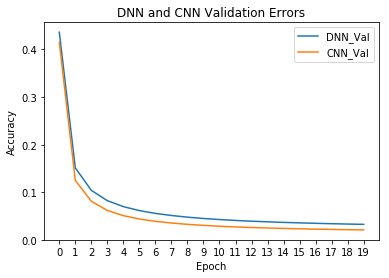

In [98]:
dnn_val_error = np.subtract(1,dnn_training_acc)
cnn_val_error = np.subtract(1, training_acc)
plt.plot(get_epoch_train(dnn_val_error), label = 'DNN_Val')
plt.plot(get_epoch_train(cnn_val_error), label = 'CNN_Val')
#plt.plot(1-get_epoch_train(dnn_training_acc), label = 'DNN_Train')
plt.legend()
plt.title('DNN and CNN Validation Errors')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 20))

In [104]:
dnn_test_cross_ent

[231.44208,
 37.596245,
 28.312687,
 23.955322,
 19.74694,
 16.957272,
 16.191187,
 15.802464,
 14.355122,
 15.121479,
 13.521196,
 13.94994,
 12.396896,
 12.632975,
 11.885731,
 12.0386715,
 11.216082,
 11.171538,
 11.079141,
 10.810454,
 10.781751,
 10.700941,
 11.010537,
 10.662947,
 10.694799,
 10.552916,
 10.593338,
 10.235792,
 10.231449,
 9.9508,
 9.322928,
 10.068743,
 10.224859,
 9.966866,
 10.020269,
 10.034309,
 9.787824,
 9.495302,
 9.879574,
 9.946131,
 9.800985,
 9.75963,
 9.750882,
 9.610172,
 9.576997,
 9.513669,
 9.908118,
 9.744646,
 9.513958,
 10.020612,
 9.775442,
 9.469998,
 9.560353,
 9.555538,
 9.475026,
 9.41777,
 9.763625,
 9.741418,
 9.86803,
 9.787024,
 9.82249,
 9.875655,
 9.937802,
 9.910905,
 9.8686,
 9.627584,
 9.49172,
 9.829611,
 9.673227,
 9.685626,
 9.688829,
 9.894509,
 9.650685,
 9.535175,
 9.537003,
 9.633533,
 9.636129,
 9.851536,
 9.856202,
 9.861621,
 9.954188,
 9.919897,
 9.868355,
 9.847136,
 9.634909,
 9.738376,
 9.873119,
 9.945397,
 9.99216

([<matplotlib.axis.XTick at 0x1848dee3c8>,
 <a list of 20 Text xticklabel objects>)

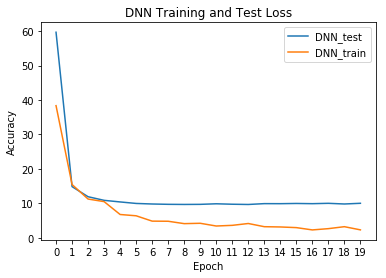

In [111]:
plt.plot(get_epoch_test(dnn_test_cross_ent), label = 'DNN_test')
plt.plot(get_epoch_train(dnn_train_cross_ent), label = 'DNN_train')
#plt.plot(1-get_epoch_train(dnn_training_acc), label = 'DNN_Train')
plt.legend()
plt.title('DNN Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 20))

([<matplotlib.axis.XTick at 0x184b5e4240>,
 <a list of 20 Text xticklabel objects>)

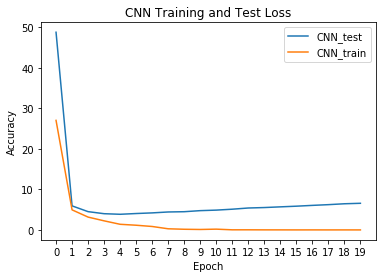

In [112]:
plt.plot(get_epoch_test(test_cross_ent), label = 'CNN_test')
plt.plot(get_epoch_train(train_cross_ent), label = 'CNN_train')
#plt.plot(1-get_epoch_train(dnn_training_acc), label = 'DNN_Train')
plt.legend()
plt.title('CNN Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(range(0, 20))